# Communication Methods & Measures - R2

### Main changes:
* Creating scatterplots for each pair of classifiers
* Reporting Krippendorff's alpha (and confidence intervals) instead of correlations
* "readability_score" module used: https://github.com/wimmuskee/readability-score)
* For Krippendorff's Alpha calculations: used same predictions as in R0 (used for precision/recall) yet with KAlpha = ordinal



# Preparation

## Configure IPython

In [1]:
# activate plots
%matplotlib inline

## Load libraries

In [2]:
from scripts_r2 import analyze # some analysis helper functions for this paper
import pandas 
import datetime
import os
import numpy
import statsmodels.formula.api as sm
import seaborn

## prepare some visualization stuff

In [3]:
seaborn.set(rc={'figure.figsize':(11.7,8.27)})
corplot = lambda cortable, title: seaborn.heatmap(cortable, linewidth=.1, annot=True, cmap="RdBu_r", vmin=-1, vmax=1).set_title(title)
tool_order = [ "recessie" , "boukes","LIWC","sentistrength","pattern","polyglot","DANEW"]
text_order = ["text_"+tool for tool in tool_order]
title_order = ["title_"+tool for tool in tool_order]

# Preprocessing

In [4]:
path_to_files = "./data"
coded_files   = "./results/data_with_sentiment.csv"
os.makedirs('results',exist_ok=True)

## Do or Load Sentiment analysis

In [5]:
# If sentiments have not yet been computed
if not os.path.exists(coded_files):
    print("Starting from scratch")
    raw_data = analyze.load_files(path_to_files)
    print("Recoding")
    rec_data = analyze.recode_annotations(raw_data) 
    print("Adding sentiment")
    sen_data = analyze.add_sentiments(analyze.add_sentiments(rec_data,'text'),'title')
    print("Adding linguistic features for error analysis")
    tex_data = analyze.add_text_properties(analyze.add_text_properties(sen_data,'text'),'title')
    print("Writing results to disk")
    tex_data.to_csv(coded_files)
    data = tex_data
# If sentiments have been computed
else:
    print("Using previously stored computations")
    data = pandas.read_csv(coded_files)

data.index = data.ID

# Add LIWC results if available
if "LIWC2015 Results (ID_Text.csv).csv" in os.listdir(path_to_files):
    text_liwc = pandas.read_csv(os.path.join(path_to_files,"LIWC2015 Results (ID_Text.csv).csv"))
    text_liwc = pandas.DataFrame({'ID':text_liwc.A, 'text_LIWC':text_liwc.Posemo - text_liwc.Negemo}).loc[2:,:]
    text_liwc.index = text_liwc.ID.astype("float64")
    data = data.join(text_liwc.drop('ID',1))
    
if "LIWC2015 Results (ID_Title.csv).csv" in os.listdir(path_to_files):
    title_liwc = pandas.read_csv(os.path.join(path_to_files,"LIWC2015 Results (ID_Title.csv).csv"))
    title_liwc = pandas.DataFrame({'ID':title_liwc.A, 'title_LIWC':title_liwc.Posemo - title_liwc.Negemo}).loc[2:,:]
    title_liwc.index = title_liwc.ID.astype("float64")
    data = data.join(title_liwc.drop('ID',1))
    
# Set time-based index
todate = lambda d: datetime.datetime.strptime(d.replace('T',' ').split('.')[0],'%Y-%m-%d %H:%M:%S')
data.index = data.date_y.map(todate) # saving as CSV breaks the timeindex, so we reconstruct it here
    

# Filter out timepoints after which data becomes too sparse
filtered = (data.index >= datetime.datetime(year=2015,month=7,day=7)).sum()
data = data[data.index < datetime.datetime(year=2015,month=7,day=7)] 
print("filtered out",filtered, "observations")

data = data[~data.index.dayofweek.isin([0,6])]

Using previously stored computations
filtered out 215 observations


In [6]:
data.isna().sum()

date_y                         0
Codeur                         0
Day_in_2015                    0
Economisch_Ja                  0
Hoofd_OW                     120
ID                             0
Posit_Nega                   121
Source                         0
Toon_Kop                     114
date_x                         0
headline                       0
outlet                         0
date_y.1                       0
type                           0
source                         0
title                          0
text                           0
online                         0
quality                        0
title_gold                  1166
text_gold                   4380
text_polyglot                  0
text_pattern                   0
text_DANEW                     0
text_boukes                    0
text_sentistrength             0
text_recessie                  0
title_polyglot                 0
title_pattern                  0
title_DANEW                    0
title_bouk

## order columns appropriately

In [7]:
data.index = range(len(data))
red = data.copy()
data = data.drop(text_order,axis=1)
data = data.drop(title_order,axis=1)
data = data.join(red[text_order])
data = data.join(red[title_order])
del(red)
data.index = data.index = data.date_y.map(todate) # saving as CSV breaks the timeindex, so we reconstruct it here

### Option to toggle non-relevant human annotations to '0'

In [8]:
#data.text_gold = data.text_gold.replace({numpy.nan:0})
#data.title_gold = data.title_gold.replace({numpy.nan:0})

## Resulting crosstabs for gold annotations

In [9]:
print("Fulltext crosstab")
pandas.DataFrame(
    {
        'online':data.text_gold[data.online].value_counts(),
        'online_%': round(data.text_gold[data.online].value_counts()/data.text_gold[data.online].value_counts().sum(),2),
        'offline':data.text_gold[~data.online].value_counts(),
        'offline_%': round(data.text_gold[~data.online].value_counts()/data.text_gold[~data.online].value_counts().sum(),2),
        'total': data.text_gold.value_counts()
    }
).sort_index()

Fulltext crosstab


,online,online_%,offline,offline_%,total
-2.0,61,0.24,265,0.23,326
-1.0,43,0.17,225,0.19,268
0.0,10,0.04,120,0.10,130
1.0,64,0.25,274,0.23,338
2.0,77,0.30,287,0.25,364


In [10]:
print("Headline crosstab")
pandas.DataFrame(
    {
        'online':data.title_gold[data.online].value_counts(),
        'online_%': round(data.title_gold[data.online].value_counts()/data.title_gold[data.online].value_counts().sum(),2),
        'offline':data.title_gold[~data.online].value_counts(),
        'offline_%': round(data.title_gold[~data.online].value_counts()/data.title_gold[~data.online].value_counts().sum(),2),
        'total': data.title_gold.value_counts()
    }
).sort_index()

Headline crosstab


,online,online_%,offline,offline_%,total
-1.0,244,0.31,1280,0.33,1524
0.0,368,0.47,1640,0.43,2008
1.0,173,0.22,935,0.24,1108


## Computing fleiss-scores

In [11]:
annotations = pandas.read_csv(os.path.join(path_to_files, "Inhoudsanalyse_AllesMerged_noICR_toneOnly.csv"),delimiter=";")
annotations = annotations.replace({" ":numpy.nan})
#annotations[["Toon_Kop","Posit_Nega"]] = annotations[["Toon_Kop","Posit_Nega"]].astype(float)


print("Headline Fleiss score, N: ", analyze.calculate_intercoder_reliability(annotations, "ID","Codeur","Toon_Kop"))
print("Fulltext Fleiss score, N: ", analyze.calculate_intercoder_reliability(annotations, "ID","Codeur","Posit_Nega"))

Headline Fleiss score, N:  (-0.054945054945054944, 8)
Fulltext Fleiss score, N:  (0.23809523809523808, 8)


## Add 'the best of the best' models

In [12]:
data = analyze.z_best(data, 'title', list(reversed(["LIWC","polyglot","sentistrength","DANEW"])))
data = analyze.z_best(data, 'text', list(reversed(["LIWC","polyglot","sentistrength","DANEW"])))

## Agregations 

In [13]:
article_data = data.copy()
daily_data   = data.copy().resample("1D").mean()
weekly_data  = data.copy().resample("1W").mean()

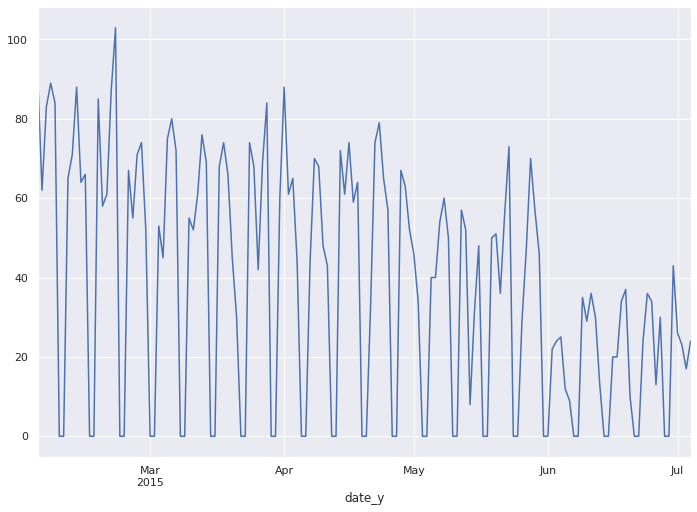

In [14]:
article_data.resample("1D").count().date_y.plot()

### Errors

In [15]:
# article level errors
article_text_errors  = analyze.calculate_errors(article_data,'text')
article_title_errors = analyze.calculate_errors(article_data,'title')
# daily level errors
daily_text_errors  = analyze.calculate_errors(daily_data, 'text')
daily_title_errors = analyze.calculate_errors(daily_data, 'title')
# weekly level errors
weekly_text_errors  = analyze.calculate_errors(weekly_data, 'text')
weekly_title_errors = analyze.calculate_errors(weekly_data, 'title')

# Scatterplots

In [16]:
analyze.export_scatterplots(article_data, "text", tool_order, "scatterplots_r2", standardization=False)

                     count      mean       std       min       25%       50%  \
text_recessie       1426.0 -0.039271  0.194306 -1.000000  0.000000  0.000000   
text_boukes         1426.0  0.575736  1.708661 -9.000000  0.000000  0.000000   
text_LIWC           1426.0  0.265035  1.197659 -4.000000 -0.430000  0.000000   
text_sentistrength  1426.0 -0.686536  0.939160 -3.000000 -1.000000 -1.000000   
text_pattern        1426.0  0.039773  0.099160 -0.575000 -0.014911  0.040563   
text_polyglot       1426.0  0.165750  0.223018 -1.000000  0.032258  0.166667   
text_DANEW          1426.0  0.045519  0.025625 -0.086960  0.029726  0.044263   
text_gold           1426.0  0.102384  1.533498 -2.000000 -1.000000  0.000000   
text_top3           1426.0  0.089412  0.722280 -2.020815 -0.375797  0.078692   

                         75%        max  
text_recessie       0.000000   0.000000  
text_boukes         1.000000  14.000000  
text_LIWC           0.910000   8.700000  
text_sentistrength  0.000000   

In [17]:
analyze.export_scatterplots(article_data, "text", tool_order, "scatterplots_r2", standardization='min-max')

                     count        mean         std  min         25%  \
text_recessie       1426.0   -0.039271    0.194306 -1.0    0.000000   
text_boukes         1426.0   -0.167327    0.148579 -1.0   -0.217391   
text_LIWC           1426.0   -0.328341    0.188608 -1.0   -0.437795   
text_sentistrength  1426.0   -0.074614    0.375664 -1.0   -0.200000   
text_pattern        1426.0    0.046421    0.168783 -1.0   -0.046656   
text_polyglot       1426.0    0.165750    0.223018 -1.0    0.032258   
text_DANEW          1426.0    0.117831    0.216215 -1.0   -0.015425   
text_gold           1426.0    0.051192    0.766749 -1.0   -0.500000   
text_top3           1426.0   -0.205520    0.271931 -1.0   -0.380666   
ID                  1426.0  712.500000  411.795054  0.0  356.250000   

                           50%          75%     max  
text_recessie         0.000000     0.000000     0.0  
text_boukes          -0.217391    -0.130435     1.0  
text_LIWC            -0.370079    -0.226772     1.0  
te

In [18]:
analyze.export_scatterplots(article_data, "text", tool_order, "scatterplots_r2", standardization='z-score')

                     count          mean         std       min         25%  \
text_recessie       1426.0 -3.927069e-02    0.194306 -1.000000    0.000000   
text_boukes         1426.0 -6.975875e-17    1.000351 -5.606200   -0.337070   
text_LIWC           1426.0 -3.114230e-17    1.000351 -3.562392   -0.580532   
text_sentistrength  1426.0  2.491384e-17    1.000351 -2.464197   -0.333888   
text_pattern        1426.0  1.993107e-17    1.000351 -6.201974   -0.551657   
text_polyglot       1426.0  3.737076e-17    1.000351 -5.228984   -0.598781   
text_DANEW          1426.0  1.245692e-17    1.000351 -5.171816   -0.616530   
text_gold           1426.0 -3.737076e-17    1.000351 -1.371454   -0.719121   
text_top3           1426.0  1.494830e-17    1.000351 -2.922646   -0.644310   
ID                  1426.0  7.125000e+02  411.795054  0.000000  356.250000   

                           50%          75%          max  
text_recessie         0.000000     0.000000     0.000000  
text_boukes          -0

In [19]:
analyze.export_scatterplots(article_data, "title", tool_order, "scatterplots_r2", standardization=False)

                      count      mean       std         min     25%       50%  \
title_recessie       4640.0 -0.001293  0.035940   -1.000000  0.0000  0.000000   
title_boukes         4640.0  0.016595  0.249043   -2.000000  0.0000  0.000000   
title_LIWC           4640.0 -0.249030  8.622618 -100.000000  0.0000  0.000000   
title_sentistrength  4640.0 -0.241164  0.808334   -3.000000  0.0000  0.000000   
title_pattern        4640.0 -0.002780  0.225720   -1.000000  0.0000  0.000000   
title_polyglot       4640.0  0.045520  0.697669   -1.000000 -0.2125  0.000000   
title_DANEW          4640.0  0.056064  0.194030   -1.326222  0.0000  0.020307   
title_gold           4640.0 -0.089655  0.747880   -1.000000 -1.0000  0.000000   
title_top3           4640.0 -0.003418  0.722481   -4.101097 -0.4002  0.085527   

                          75%         max  
title_recessie       0.000000    0.000000  
title_boukes         0.000000    2.000000  
title_LIWC           0.000000  100.000000  
title_sentist

In [20]:
analyze.export_scatterplots(article_data, "title", tool_order, "scatterplots_r2", standardization='min-max')

                      count         mean          std  min          25%  \
title_recessie       4640.0    -0.001293     0.035940 -1.0     0.000000   
title_boukes         4640.0     0.008297     0.124522 -1.0     0.000000   
title_LIWC           4640.0    -0.002490     0.086226 -1.0     0.000000   
title_sentistrength  4640.0    -0.080388     0.269445 -1.0     0.000000   
title_pattern        4640.0     0.017571     0.230326 -1.0     0.020408   
title_polyglot       4640.0     0.045520     0.697669 -1.0    -0.212500   
title_DANEW          4640.0    -0.236306     0.107199 -1.0    -0.267280   
title_gold           4640.0    -0.089655     0.747880 -1.0    -1.000000   
title_top3           4640.0    -0.021245     0.172569 -1.0    -0.116019   
ID                   4640.0  2319.500000  1339.596954  0.0  1159.750000   

                              50%          75%     max  
title_recessie       0.000000e+00     0.000000     0.0  
title_boukes         0.000000e+00     0.000000     1.0  
tit

In [21]:
analyze.export_scatterplots(article_data, "title", tool_order, "scatterplots_r2", standardization='z-score')

                      count          mean          std        min  \
title_recessie       4640.0 -1.293103e-03     0.035940  -1.000000   
title_boukes         4640.0 -7.656711e-19     1.000108  -8.098246   
title_LIWC           4640.0  1.531342e-17     1.000108 -11.569771   
title_sentistrength  4640.0 -3.062684e-17     1.000108  -3.413360   
title_pattern        4640.0 -3.062684e-18     1.000108  -4.418431   
title_polyglot       4640.0 -1.837611e-17     1.000108  -1.498752   
title_DANEW          4640.0  3.062684e-18     1.000108  -7.124836   
title_gold           4640.0 -1.225074e-17     1.000108  -1.217366   
title_top3           4640.0  9.188053e-18     1.000108  -5.672284   
ID                   4640.0  2.319500e+03  1339.596954   0.000000   

                             25%          50%          75%          max  
title_recessie          0.000000     0.000000     0.000000     0.000000  
title_boukes           -0.066642    -0.066642    -0.066642     7.964963  
title_LIWC        

# Intercoder reliability across tools

In [23]:
analyze.export_for_check_intercoder(article_data,'text', 'kalpha_results_r2', trinairize=True,trinary_cutoff=0.5, beta=1, errors=False, normalization='zscore')

text_recessie
text_boukes
text_LIWC
text_sentistrength
text_pattern
text_polyglot
text_DANEW
text_top4
text_top3
text_top2
text_top1


In [24]:
analyze.export_for_check_intercoder(article_data,'title', 'kalpha_results_r2', trinairize=True,trinary_cutoff=0.5, beta=1, errors=False, normalization='zscore')

title_recessie
title_boukes
title_LIWC
title_sentistrength
title_pattern
title_polyglot
title_DANEW
title_top4
title_top3
title_top2
title_top1


In [25]:
data['title_LIWC'].describe()

count    5806.000000
mean       -0.204487
std         9.007601
min      -100.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       100.000000
Name: title_LIWC, dtype: float64